In [ ]:
import numpy as np 
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

In [16]:
# under damped osc
def exact_solution(d,w0,t):
#     as we are considering the case of under damped osc 
    assert d<w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

True value of mu: 4


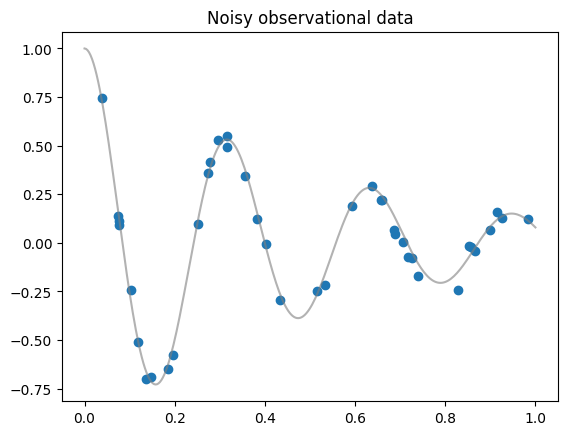

In [17]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0])
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="grey", alpha=0.6)
plt.show()

In [18]:
# a standard fully connected neural network
class FCN(nn.Module):
    def __init__(self, n_i ,n_o , n_h , n_l ) :
#         note : n_i,n_o etc are number of input, output, hidden, layers
        super().__init__()
        activation = nn.Tanh
    #     fcs : fully connected start 
    #     fch : fully connected hidden 
    #     fce : fully connected end 
        self.fcs = nn.Sequential(
                        nn.Linear(n_i , n_h),
                        activation())
        self.fch = nn.Sequential(
                        nn.Linear(n_h,n_h),
                        activation())
        self.fce = nn.Linear(n_h , n_o)

    def forward (self,x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

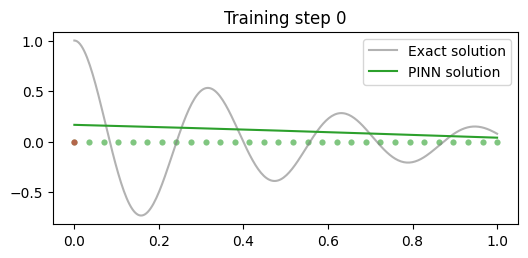

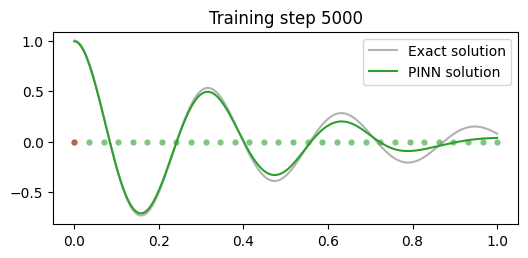

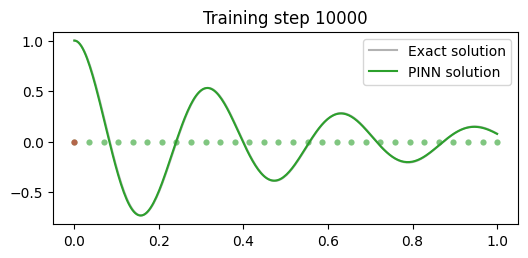

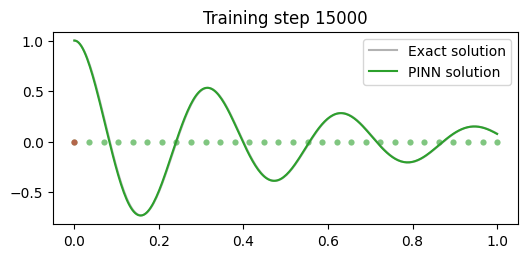

In [19]:
torch.manual_seed(123)

pinn = FCN(1,1,32,3)

#      basically 1st is the dimension of input here ip is just times so 1
#      2nd is output which is just the answer so 1 
#      3rd is the number of hidden units 
#      4th is the number of layers which is pretty much redundant tbh

# defining training points 
# 1st for boundary loss which just 0 
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# 2nd for physics loss that is the sampling over 0 to 1 we talked about 
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)


# training the pinn
d , w0 = 2 , 20
mu , k = 2*d , w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d,w0,t_test)
optimizer = torch.optim.Adam(pinn.parameters(),lr = 1e-3)

for i in range (15001) :
    optimizer.zero_grad()
    
    lambda1 ,lambda2 = 1e-1 , 1e-4
    
#     compute boundary loss
    u = pinn(t_boundary) # 1,1
    loss1 = (torch.squeeze(u) - 1)**2
    
    dudt = torch.autograd.grad(u,t_boundary , torch.ones_like(u) , create_graph = True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
#     compute boundary loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u , t_physics , torch.ones_like(u), create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt , t_physics , torch.ones_like(dudt), create_graph = True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    
#     COPIED
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

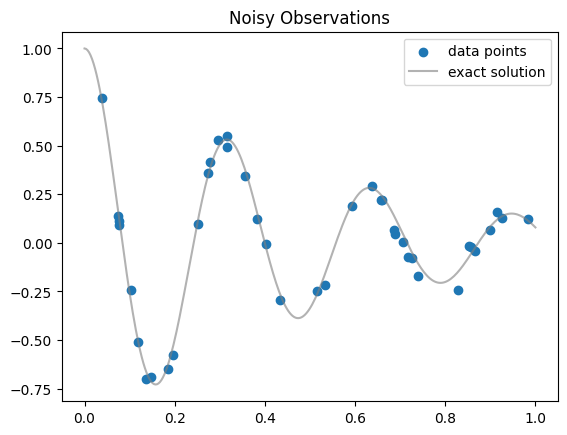

In [38]:
# INVERSION 
# HERE MU IS ALSO A LEARNABLE PARAMETER 
# AGAIN CREATING SOME NOISY DATA
torch.manual_seed(123)
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d,w0,t_obs) + 0.04 * torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy Observations")
plt.scatter(t_obs[:,0] , u_obs[:,0] , label = "data points")
t_exact = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d,w0,t_exact)
plt.plot(t_exact , u_exact , color = "grey" , alpha = 0.6 , label = "exact solution")
plt.legend()
plt.show()

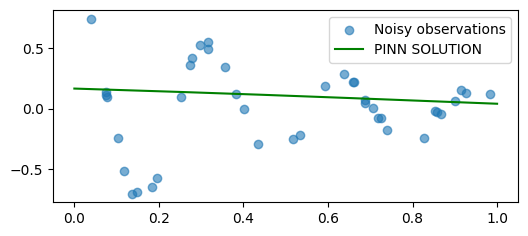

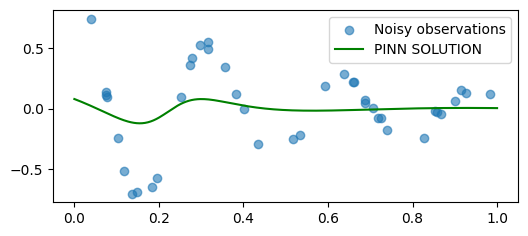

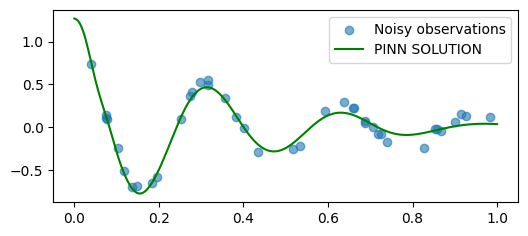

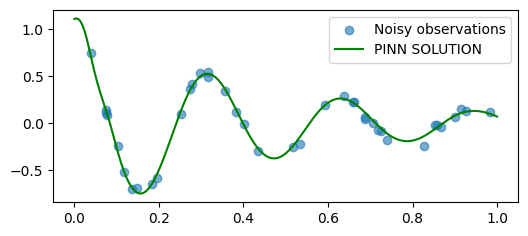

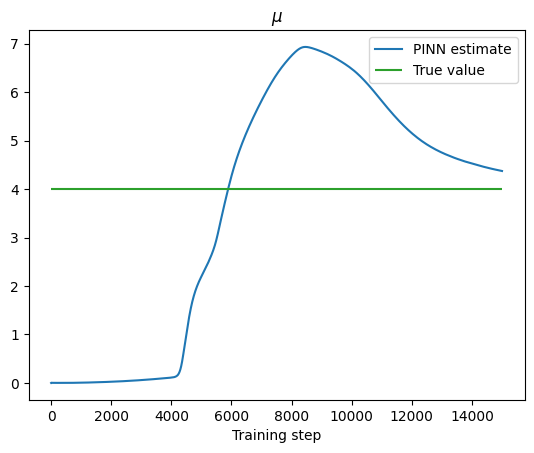

In [50]:
torch.manual_seed(123)

pinn = FCN(1,1,32,3)

t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

d, w0 = 2,20
_,k = 2*d,w0**2
mus = []

# here we treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad = True))
#  note this we add mu to the list of parameters in a special way 
optimizer = torch.optim.Adam(list(pinn.parameters())+[mu] , lr = 1e-3)

for i in range(15001):
    optimizer.zero_grad()
    lambda1 = 1e4
    
#     physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u , t_physics , torch.ones_like(u) , create_graph = True)[0]
    d2udt2 = torch.autograd.grad(dudt , t_physics , torch.ones_like(dudt) , create_graph = True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt +k*u)**2)
    
#     data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)
    
    loss = loss1 + lambda1 * loss2
    loss.backward()
    optimizer.step()
    
    mus.append(mu.item())
    
#     plot
    if i%5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize = (6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0],label = "Noisy observations" , alpha = 0.6)
        plt.plot(t_test[:,0], u[:,0], label = "PINN SOLUTION" , color = "green")
        plt.legend()
        
plt.figure()
plt.title("$\mu$")
plt.plot(mus, label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()

In [44]:
list(pinn.parameters())+[mu] != [pinn.parameters() , mu]

True